In [1]:
import json

from pathlib import Path

In [2]:
DATASET_ROOT_PATH = Path('../dataset/')

In [3]:
def load_split(path: Path) -> dict:
    with path.open("r") as f:
        dataset = json.load(f)

    return dataset

In [4]:
train_json = load_split(path=DATASET_ROOT_PATH / 'train.json')

In [5]:
data_sample = train_json[0]
for key, value in data_sample.items():
    print(f"{key}: {type(value)}")
    print(f"{key}: {value}")
    print()

pre_text: <class 'list'>
pre_text: ['interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .', 'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .', 'foreign currency exposure as more fully described in note 2i .', 'in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .', 'dollar-based exposures by entering into forward foreign currency exchange contracts .', 'the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .', 'currently , our largest foreign currency exposure is the euro , primarily because our european operations have the highest proportion of our local currency denominated expenses .', 'relative to foreign currency exposures existing at october 31 , 2009 and november 1 ,

In [6]:
for key, value in data_sample['qa'].items():
    print(f"{key}: {type(value)}")
    print(f"{key}: {value}")
    print()

question: <class 'str'>
question: what is the the interest expense in 2009?

answer: <class 'str'>
answer: 380

explanation: <class 'str'>
explanation: 

ann_table_rows: <class 'list'>
ann_table_rows: []

ann_text_rows: <class 'list'>
ann_text_rows: [1]

steps: <class 'list'>
steps: [{'op': 'divide1-1', 'arg1': '100', 'arg2': '100', 'res': '1%'}, {'op': 'divide1-2', 'arg1': '3.8', 'arg2': '#0', 'res': '380'}]

program: <class 'str'>
program: divide(100, 100), divide(3.8, #0)

gold_inds: <class 'dict'>
gold_inds: {'text_1': 'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .'}

exe_ans: <class 'float'>
exe_ans: 3.8

tfidftopn: <class 'dict'>
tfidftopn: {'text_14': 'dollar , would have on the fair value of our forward exchange contracts as of october 31 , 2009 and november 1 , 2008: .', 'text_0': 'interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .'}



In [7]:
from tqdm import tqdm

flattened_train_json = []
for data_sample in tqdm(train_json):
    flattened_train_json.append({
        "pre_text": data_sample["pre_text"],
        "table": data_sample["table"],
        "post_text": data_sample["post_text"],
        "question": data_sample["qa"]["question"],
        "answer": data_sample["qa"]["answer"],
        "program": data_sample["qa"]["program"],
    })

100%|██████████| 6251/6251 [00:00<00:00, 803511.93it/s]


In [8]:
from datasets import Dataset

train_dataset = Dataset.from_list(flattened_train_json)
train_dataset

/home/pauliusztin/anaconda3/envs/hands-on-llms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['pre_text', 'table', 'post_text', 'question', 'answer', 'program'],
    num_rows: 6251
})

In [9]:
train_dataset[0]

{'pre_text': ['interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .',
  'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .',
  'foreign currency exposure as more fully described in note 2i .',
  'in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .',
  'dollar-based exposures by entering into forward foreign currency exchange contracts .',
  'the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .',
  'currently , our largest foreign currency exposure is the euro , primarily because our european operations have the highest proportion of our local currency denominated expenses .',
  'relative to foreign currency exposures existing at october 31 , 2009 and november 1 , 2008 , 

In [10]:
def create_prompt(data_sample: dict) -> str:
    pre_text = data_sample['pre_text']
    pre_text = "\n".join(pre_text)

    table = data_sample['table']
    table_rows = []
    for table_row in table:
        table_row = " | ".join(table_row)
        table_rows.append(table_row)
    table = "\n".join(table_rows)

    post_text = data_sample['post_text']
    post_text = "\n".join(post_text)

    program = data_sample['program']

    prompt = f"\
    You are a professional financial advisor. Your task is to read the following financial report delimited by ###START_FINANCIAL_REPORT and END_FINANCIAL_REPORT#### and answer the question followed by ###QUESTION.\n \
    ###START_FINANCIAL_REPORT\n \
    {pre_text}\n \
    TABLE:\n \
    {table}\n \
    {post_text}\n \
    ###END_FINANCIAL_REPORT\n \
    ###QUESTION: {data_sample['question']}\n \
    These are the steps that got me to the answer:\n \
    ####STEPS: {program}\n \
    This is the final answer:\n \
    ###ANSWER: {data_sample['answer']} \
    "

    return {
        "text": prompt,
    }


def create_test_prompt(data_sample: dict) -> str:
    pre_text = data_sample['pre_text']
    pre_text = "\n".join(pre_text)

    table = data_sample['table']
    table_rows = []
    for table_row in table:
        table_row = " | ".join(table_row)
        table_rows.append(table_row)
    table = "\n".join(table_rows)

    post_text = data_sample['post_text']
    post_text = "\n".join(post_text)

    prompt = f"\
    You are a professional financial advisor. Your task is to read the following financial report delimited by ###START_FINANCIAL_REPORT and END_FINANCIAL_REPORT#### and answer the question followed by ###QUESTION.\n \
    ###START_FINANCIAL_REPORT\n \
    {pre_text}\n \
    TABLE:\n \
    {table}\n \
    {post_text}\n \
    ###END_FINANCIAL_REPORT\n \
    ###QUESTION: {data_sample['question']}\n \
    "

    return {
        "text": prompt,
    }

In [11]:
train_dataset = train_dataset.map(lambda data_sample: create_prompt(data_sample), remove_columns=train_dataset.column_names)
train_dataset

Dataset({
    features: ['text'],
    num_rows: 6251
})

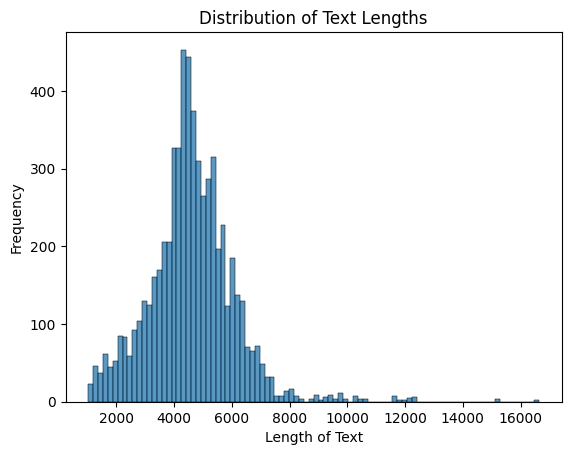

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset = train_dataset.map(lambda example: {"text_length": len(example["text"])})

# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()

# Plot the distribution of text lengths
sns.histplot(df["text_length"])
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [13]:
import sys
sys.path.append("../modules")

from datasets import load_dataset
from transformers import TrainingArguments
from trl import SFTTrainer

from training import models

In [14]:
model, tokenizer, peft_config = models.build_qlora_model()
# TODO: Do I need this?
model.config.use_cache = (
    False  # Gradient checkpointing is used by default but not compatible with caching
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


In [15]:
training_arguments = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,  # increase this value if you have more VRAM
    gradient_accumulation_steps=16,
    optim="paged_adamw_32bit",  # This parameter activate QLoRa's pagination
    save_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=1,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
)

In [16]:
# # TODO: Check if a token is a word or character.
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=train_dataset,
#     peft_config=peft_config,
#     dataset_text_field="text",
#     max_seq_length=1024,
#     tokenizer=tokenizer,
#     args=training_arguments,
#     packing=True,
# )
# trainer.train()

In [19]:
# TODO: Test the model on the test set.
data_sample = flattened_train_json[0]
data_sample_prompt = create_test_prompt(data_sample)
data_sample_prompt["text"]


'    You are a professional financial advisor. Your task is to read the following financial report delimited by ###START_FINANCIAL_REPORT and END_FINANCIAL_REPORT#### and answer the question followed by ###QUESTION.\n     ###START_FINANCIAL_REPORT\n     interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .\nif libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .\nforeign currency exposure as more fully described in note 2i .\nin the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .\ndollar-based exposures by entering into forward foreign currency exchange contracts .\nthe terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .\ncurrently , our largest foreign currency exposure is the euro 

In [20]:
loaded_model, loaded_tokenizer, _ = models.build_qlora_model(peft_model_id="results/checkpoint-10/")

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]


In [22]:
print(
    models.prompt(
        model=loaded_model,
        tokenizer=loaded_tokenizer,
        input_text=data_sample_prompt["text"],
    )
)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


    You are a professional financial advisor. Your task is to read the following financial report delimited by ###START_FINANCIAL_REPORT and END_FINANCIAL_REPORT#### and answer the question followed by ###QUESTION.
     ###START_FINANCIAL_REPORT
     interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31, 2009 ).
if libor changes by 100 basis points, our annual interest expense would change by $ 3.8 million.
foreign currency exposure as more fully described in note 2i.
in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k, we regularly hedge our non-u.s.
dollar-based exposures by entering into forward foreign currency exchange contracts.
the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months.
currently, our largest foreign currency exposure is the euro, primarily because 